In [14]:
import os
import re
import json
import random
import urllib.request
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [6]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [7]:
DATA_DIR = Path("data")
RAW_DIR = DATA_DIR / "raw"
MODEL_DIR = Path("models")

In [38]:
NUM_CLASSES = 50
MAX_SAMPLES_PER_CLASS = 40000
BATCH_SIZE = 512
EPOCHS = 20

In [9]:
def ensure_dirs_exist():
    DATA_DIR.mkdir(exist_ok=True)
    RAW_DIR.mkdir(exist_ok=True, parents=True)
    MODEL_DIR.mkdir(exist_ok=True)

In [11]:
ensure_dirs_exist()

In [16]:
def get_all_class_names():
    path = DATA_DIR / 'all_classes.txt'
    
    with path.open('r', encoding='utf-8') as f:
        text = f.read()
    
    classes = re.findall(r'"([^"]+)"', text)
    
    print(f"Found {len(classes)} classes.")
    return classes

In [29]:
def select_random_classes(num_classes=NUM_CLASSES):
    all_classes = get_all_class_names()
    random.seed(42)
    selected_classes = random.sample(all_classes, num_classes)

    with open(DATA_DIR / "selected_classes.json", "w") as f:
        json.dump(selected_classes, f)
    
    print(f"Selected {num_classes} random classes:")
    for i, cls in enumerate(selected_classes[:10]):
        print(f"  {i+1}. {cls}")
    if num_classes > 10:
        print(f"  ... and {num_classes-10} more")
    
    return selected_classes

In [34]:
selected_classes = select_random_classes(NUM_CLASSES)

Found 345 classes.
Selected 50 random classes:
  1. t-shirt
  2. campfire
  3. backpack
  4. headphones
  5. frog
  6. fireplace
  7. circle
  8. calculator
  9. square
  10. broom
  ... and 40 more


In [35]:
def download_class_np(class_name):
    url_name = class_name.replace(" ", "%20")
    url = f"https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/{url_name}.npy"
    local_file = RAW_DIR / f"{class_name}.npy"
    
    if not local_file.exists():
        print(f"Downloading {class_name}...")
        try:
            urllib.request.urlretrieve(url, local_file)
            print(f"Successfully downloaded {class_name}")
        except Exception as e:
            print(f"Error downloading {class_name}")
    else:
        print(f"File for {class_name} already exists, skipping download")
    
    return local_file

In [36]:
def download_dataset(class_names):
    print(f"\nDownloading {len(class_names)} class files...")
    downloaded_files = []
    
    for class_name in tqdm(class_names, desc="Downloading"):
        file_path = download_class_np(class_name)
        if file_path:
            downloaded_files.append(file_path)
    
    print(f"Downloaded {len(downloaded_files)} class files")
    return downloaded_files

In [37]:
download_dataset(selected_classes)

Downloading:   0%|                                       | 0/50 [00:00<?, ?it/s]

Downloading:   2%|▌                              | 1/50 [00:02<02:03,  2.52s/it]

Successfully downloaded t-shirt


Downloading:   4%|█▏                             | 2/50 [00:04<01:51,  2.33s/it]

Successfully downloaded campfire


Downloading:   6%|█▊                             | 3/50 [00:06<01:41,  2.16s/it]

Successfully downloaded backpack


Downloading:   8%|██▍                            | 4/50 [00:08<01:39,  2.16s/it]

Successfully downloaded headphones


Downloading:  10%|███                            | 5/50 [00:11<01:45,  2.34s/it]

Successfully downloaded frog


Downloading:  12%|███▋                           | 6/50 [00:14<01:50,  2.52s/it]

Successfully downloaded fireplace


Downloading:  14%|████▎                          | 7/50 [00:16<01:41,  2.37s/it]

Successfully downloaded circle


Downloading:  16%|████▉                          | 8/50 [00:19<01:46,  2.53s/it]

Successfully downloaded calculator


Downloading:  18%|█████▌                         | 9/50 [00:21<01:37,  2.38s/it]

Successfully downloaded square


Downloading:  20%|██████                        | 10/50 [00:23<01:37,  2.44s/it]

Successfully downloaded broom


Downloading:  22%|██████▌                       | 11/50 [00:25<01:30,  2.31s/it]

Successfully downloaded teapot


Downloading:  24%|███████▏                      | 12/50 [00:28<01:28,  2.33s/it]

Successfully downloaded peas


Downloading:  26%|███████▊                      | 13/50 [00:30<01:27,  2.35s/it]

Successfully downloaded baseball


Downloading:  28%|████████▍                     | 14/50 [00:33<01:27,  2.43s/it]

Successfully downloaded barn


Downloading:  30%|█████████                     | 15/50 [00:36<01:28,  2.53s/it]

Successfully downloaded bus


Downloading:  32%|█████████▌                    | 16/50 [00:38<01:29,  2.63s/it]

Successfully downloaded fence


Downloading:  34%|██████████▏                   | 17/50 [00:41<01:24,  2.57s/it]

Successfully downloaded flip flops


Downloading:  36%|██████████▊                   | 18/50 [00:43<01:19,  2.50s/it]

Successfully downloaded sheep


Downloading:  38%|███████████▍                  | 19/50 [00:45<01:12,  2.34s/it]

Successfully downloaded The Eiffel Tower


Downloading:  40%|████████████                  | 20/50 [00:49<01:27,  2.91s/it]

Successfully downloaded banana


Downloading:  42%|████████████▌                 | 21/50 [00:52<01:19,  2.74s/it]

Successfully downloaded stitches


Downloading:  44%|█████████████▏                | 22/50 [00:54<01:11,  2.57s/it]

Successfully downloaded ear


Downloading:  46%|█████████████▊                | 23/50 [00:57<01:16,  2.83s/it]

Successfully downloaded violin


Downloading:  48%|██████████████▍               | 24/50 [01:00<01:10,  2.70s/it]

Successfully downloaded peanut


Downloading:  50%|███████████████               | 25/50 [01:02<01:05,  2.63s/it]

Successfully downloaded finger


Downloading:  52%|███████████████▌              | 26/50 [01:05<01:01,  2.57s/it]

Successfully downloaded pool


Downloading:  54%|████████████████▏             | 27/50 [01:07<00:59,  2.57s/it]

Successfully downloaded table


Downloading:  56%|████████████████▊             | 28/50 [01:10<01:00,  2.73s/it]

Successfully downloaded helicopter


Downloading:  58%|█████████████████▍            | 29/50 [01:13<00:56,  2.71s/it]

Successfully downloaded ambulance


Downloading:  60%|██████████████████            | 30/50 [01:15<00:48,  2.41s/it]

Successfully downloaded cow


Downloading:  62%|██████████████████▌           | 31/50 [01:17<00:42,  2.24s/it]

Successfully downloaded lion


Downloading:  64%|███████████████████▏          | 32/50 [01:20<00:47,  2.65s/it]

Successfully downloaded cooler


Downloading:  66%|███████████████████▊          | 33/50 [01:22<00:41,  2.44s/it]

Successfully downloaded feather


Downloading:  68%|████████████████████▍         | 34/50 [01:24<00:37,  2.37s/it]

Successfully downloaded lightning


Downloading:  70%|█████████████████████         | 35/50 [01:26<00:34,  2.29s/it]

Successfully downloaded mug


Downloading:  72%|█████████████████████▌        | 36/50 [01:28<00:30,  2.20s/it]

Successfully downloaded butterfly


Downloading:  74%|██████████████████████▏       | 37/50 [01:31<00:31,  2.42s/it]

Successfully downloaded mermaid


Downloading:  76%|██████████████████████▊       | 38/50 [01:34<00:28,  2.37s/it]

Successfully downloaded lobster


Downloading:  78%|███████████████████████▍      | 39/50 [01:37<00:28,  2.62s/it]

Successfully downloaded The Great Wall of China


Downloading:  80%|████████████████████████      | 40/50 [01:39<00:25,  2.53s/it]

Successfully downloaded hamburger


Downloading:  82%|████████████████████████▌     | 41/50 [01:41<00:21,  2.36s/it]

Successfully downloaded beach


Downloading:  84%|█████████████████████████▏    | 42/50 [01:43<00:18,  2.34s/it]

Successfully downloaded rabbit


Downloading:  86%|█████████████████████████▊    | 43/50 [01:47<00:18,  2.60s/it]

Successfully downloaded sock


Downloading:  88%|██████████████████████████▍   | 44/50 [01:49<00:14,  2.42s/it]

Successfully downloaded castle


Downloading:  90%|███████████████████████████   | 45/50 [01:51<00:11,  2.32s/it]

Successfully downloaded mouth


Downloading:  92%|███████████████████████████▌  | 46/50 [01:53<00:08,  2.24s/it]

Successfully downloaded brain


Downloading:  94%|████████████████████████████▏ | 47/50 [01:55<00:06,  2.14s/it]

Successfully downloaded stairs


Downloading:  96%|████████████████████████████▊ | 48/50 [01:57<00:04,  2.25s/it]

Successfully downloaded hot dog


Downloading:  98%|█████████████████████████████▍| 49/50 [01:59<00:02,  2.20s/it]

Successfully downloaded train


Downloading: 100%|██████████████████████████████| 50/50 [02:01<00:00,  2.43s/it]

Successfully downloaded toothbrush
Downloaded 50 class files


[PosixPath('data/raw/t-shirt.npy'),
 PosixPath('data/raw/campfire.npy'),
 PosixPath('data/raw/backpack.npy'),
 PosixPath('data/raw/headphones.npy'),
 PosixPath('data/raw/frog.npy'),
 PosixPath('data/raw/fireplace.npy'),
 PosixPath('data/raw/circle.npy'),
 PosixPath('data/raw/calculator.npy'),
 PosixPath('data/raw/square.npy'),
 PosixPath('data/raw/broom.npy'),
 PosixPath('data/raw/teapot.npy'),
 PosixPath('data/raw/peas.npy'),
 PosixPath('data/raw/baseball.npy'),
 PosixPath('data/raw/barn.npy'),
 PosixPath('data/raw/bus.npy'),
 PosixPath('data/raw/fence.npy'),
 PosixPath('data/raw/flip flops.npy'),
 PosixPath('data/raw/sheep.npy'),
 PosixPath('data/raw/The Eiffel Tower.npy'),
 PosixPath('data/raw/banana.npy'),
 PosixPath('data/raw/stitches.npy'),
 PosixPath('data/raw/ear.npy'),
 PosixPath('data/raw/violin.npy'),
 PosixPath('data/raw/peanut.npy'),
 PosixPath('data/raw/finger.npy'),
 PosixPath('data/raw/pool.npy'),
 PosixPath('data/raw/table.npy'),
 PosixPath('data/raw/helicopter.npy'),


In [39]:
def load_and_preprocess_data(class_names):
    print("\nLoading and preprocessing data...")
    X, y = [], []
    
    for idx, class_name in enumerate(tqdm(class_names, desc="Loading")):
        try:
            file_path = RAW_DIR / f"{class_name}.npy"
            class_data = np.load(file_path)
            
            if len(class_data) > MAX_SAMPLES_PER_CLASS:
                indices = np.random.choice(len(class_data), MAX_SAMPLES_PER_CLASS, replace=False)
                class_data = class_data[indices]
            
            class_data = class_data.astype("float32") / 255.0

            X.append(class_data)
            y.append(np.full(len(class_data), idx, dtype="int32"))
            
        except Exception as e:
            print(f"Error loading {class_name}: {e}")
    
    X = np.concatenate(X)
    y = np.concatenate(y)
    
    print(f"Total samples: {X.shape[0]}")

    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42)
    
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)
    
    X_train = X_train.reshape(-1, 28, 28, 1)
    X_val = X_val.reshape(-1, 28, 28, 1)
    X_test = X_test.reshape(-1, 28, 28, 1)
    
    print(f"Train set: {X_train.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [40]:
X_train, X_val, X_test, y_train, y_val, y_test = load_and_preprocess_data(selected_classes)


Loading and preprocessing data...


Loading: 100%|██████████████████████████████████| 50/50 [00:08<00:00,  6.18it/s]


Total samples: 2000000
Train set: 1600000 samples
Validation set: 200000 samples
Test set: 200000 samples


In [43]:
def build_model(num_classes=NUM_CLASSES):
    model = models.Sequential([
        
        # First convolutional block
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.25),
        
        # Second convolutional block
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.25),
        
        # Fully connected layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    # Compile the model
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [44]:
model = build_model(NUM_CLASSES)
model.summary()

/opt/anaconda3/envs/projects/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │        12,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 341,650 (1.30 MB)

 Trainable params: 340,946 (1.30 MB)

 Non-trainable params: 704 (2.75 KB)

In [45]:
def train_model(model, X_train, y_train, X_val, y_val):
    print("\nTraining model...")
    
    # Define callbacks
    callbacks = [
        ReduceLROnPlateau(factor=0.3, patience=3, min_lr=1e-6, verbose=1),
        EarlyStopping(patience=5, restore_best_weights=True, verbose=1)
    ]
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=callbacks,
        verbose=1
    )
    
    return history

In [46]:
history = train_model(model, X_train, y_train, X_val, y_val)


Training model...
Epoch 1/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 668s 213ms/step - accuracy: 0.6210 - loss: 1.4876 - val_accuracy: 0.8312 - val_loss: 0.6416 - learning_rate: 0.0010
Epoch 2/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 620s 198ms/step - accuracy: 0.7963 - loss: 0.7766 - val_accuracy: 0.8505 - val_loss: 0.5680 - learning_rate: 0.0010
Epoch 3/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 607s 194ms/step - accuracy: 0.8128 - loss: 0.7154 - val_accuracy: 0.8557 - val_loss: 0.5487 - learning_rate: 0.0010
Epoch 4/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 604s 193ms/step - accuracy: 0.8209 - loss: 0.6846 - val_accuracy: 0.8620 - val_loss: 0.5260 - learning_rate: 0.0010
Epoch 5/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 603s 193ms/step - accuracy: 0.8257 - loss: 0.6654 - val_accuracy: 0.8632 - val_loss: 0.5216 - learning_rate: 0.0010
Epoch 6/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 614s 197ms/step - accuracy: 0.8296 - loss: 0.6518 - val_accuracy: 0.8670 - val_loss: 0.5081 - learning_rate: 0.0010
Epoch 7/20
3125/3125 ━━━━━━━━━━━━

In [47]:
def plot_learning_curves(history):
    plt.figure(figsize=(12, 4))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()

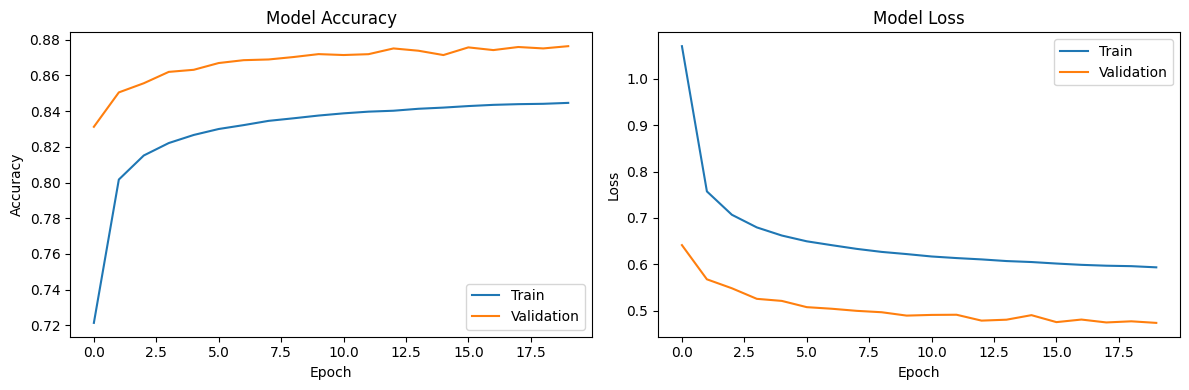

In [48]:
plot_learning_curves(history)

In [49]:
def evaluate_model(model, X_test, y_test, class_names):
    print("\nEvaluating model...")
    
    # Evaluate on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test accuracy: {test_acc:.4f}")
    
    # Generate predictions
    y_pred = np.argmax(model.predict(X_test), axis=1)
    
    # Plot confusion matrix
    plt.figure(figsize=(12, 12))
    cm = confusion_matrix(y_test, y_pred)
    
    # Use abbreviated class names for better visualization
    short_names = [name[:10] + "..." if len(name) > 10 else name for name in class_names]
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=short_names)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=90)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    
    # Plot some example predictions
    plt.figure(figsize=(12, 8))
    for i in range(15):  # Show 15 examples
        plt.subplot(3, 5, i + 1)
        plt.imshow(X_test[i].reshape(28, 28), cmap='gray')
        pred_idx = y_pred[i]
        true_idx = y_test[i]
        title = f"True: {class_names[true_idx]}\nPred: {class_names[pred_idx]}"
        plt.title(title, fontsize=8)
        plt.axis('off')
    plt.tight_layout()


Evaluating model...
Test accuracy: 0.8770
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step
Confusion matrix saved to data/confusion_matrix.png


<Figure size 1200x1200 with 0 Axes>

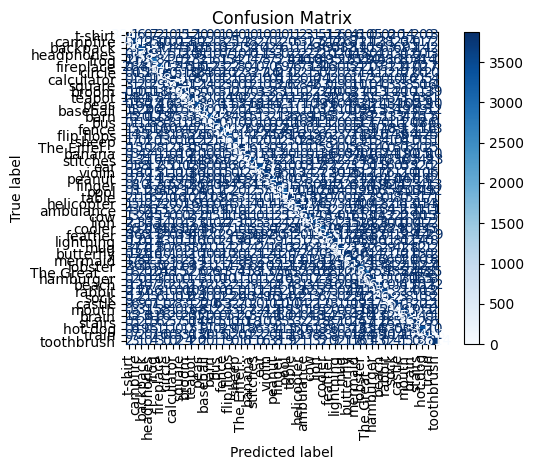

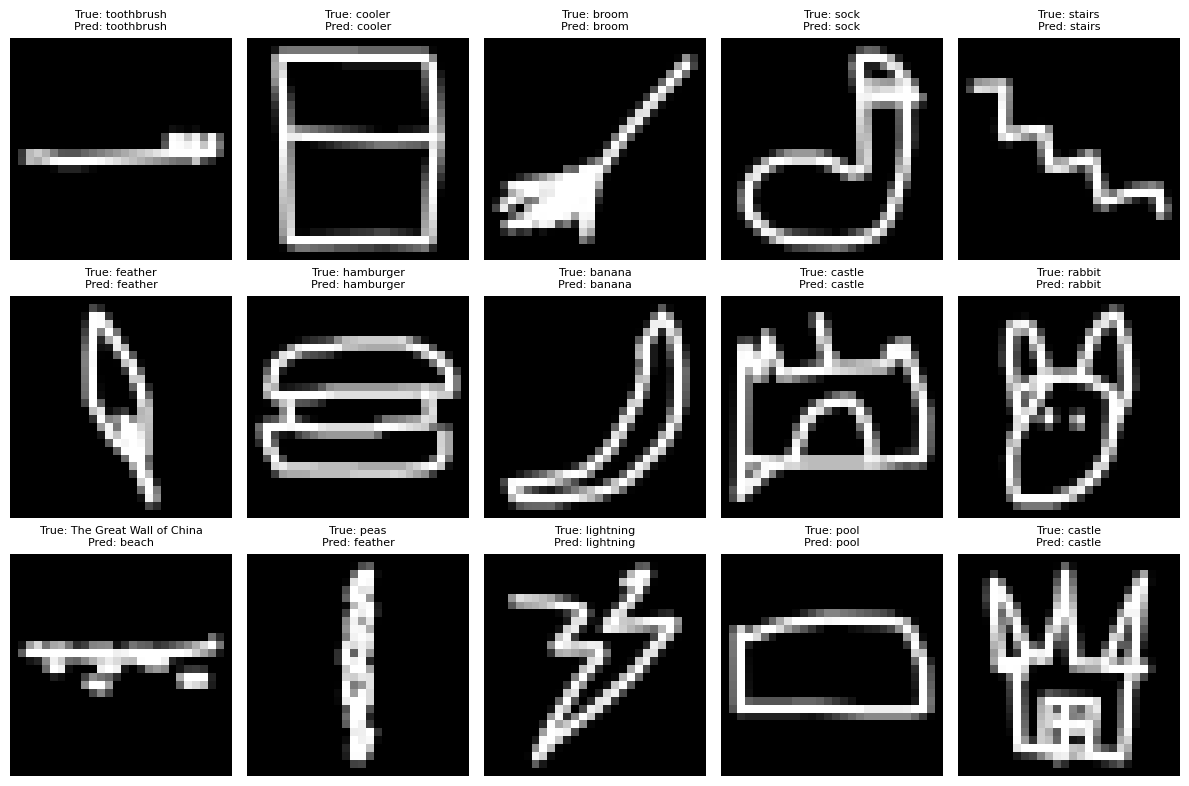

In [50]:
evaluate_model(model, X_test, y_test, selected_classes)

In [ ]:
def save_model(model):
    model_path = MODEL_DIR / "quick_draw_model"
    model.save(model_path)
    print(f"\nModel saved to {model_path}")

In [ ]:
save_model(model)